In [1]:
from wiki import WikiCorpus, PICKLE_FILE, CORPUS_DIR
from tqdm import tqdm

try:
    corpus = WikiCorpus.from_pickle(PICKLE_FILE)
except FileNotFoundError:
    corpus = WikiCorpus.from_corpus_files()
    corpus.generate_network('all_users', normalize_edge_weights=False)
    corpus.to_pickle(PICKLE_FILE)

100%|██████████| 26397/26397 [00:00<00:00, 224276.11it/s]

Opening pickle...
Opening corpus files...
Loading users...
Loading posts...



  0%|          | 72/389121 [00:00<09:06, 712.13it/s]

Setting up corpus...


  6%|▌         | 23949/389121 [00:00<00:01, 239485.09it/s]

Generating network ...


100%|██████████| 389121/389121 [00:00<00:00, 394115.30it/s]


There were 30356 posts to/from unknown users.
The unpruned network has  22495 nodes.
Pruning network to its largest component...
	 removed 398 users from 192 disconnected components.


# Social Network Features

### Eigenvector centrality

In [2]:
import networkx as nx
import numpy

eigen_central = nx.eigenvector_centrality_numpy(corpus.networks['all_users'])
corpus.register_user_data('eigen_central', eigen_central)

mean = numpy.mean(list(eigen_central.values()))
stddev = numpy.std(list(eigen_central.values()))
eigen_central_bin = {user: e > mean + stddev for user, e in eigen_central.items()}
corpus.register_user_data('eigen_central_bin', eigen_central_bin)

### Community clustering (Louvain)

In [3]:
import community # https://github.com/taynaud/python-louvain

partition = community.best_partition(corpus.networks['all_users'])
corpus.register_user_data('community', partition)

We can visualize the Wikipedia network by considering community cluster as its own node.

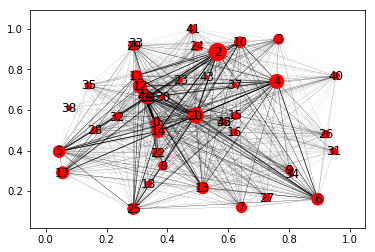

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log

clusters = nx.Graph()
clusters.add_nodes_from(set(partition.values()), weight=0)

for user in corpus.networks['all_users'].nodes():
    clusters.node[partition[user]]['weight'] += 1

for (u, v), weight in nx.get_edge_attributes(corpus.networks['all_users'], 'weight').items():
    u, v = partition[u], partition[v]
    if not clusters.has_edge(u, v):
        clusters.add_edge(u, v, weight=weight)
    else:
        clusters.edge[u][v]['weight'] += weight
        
nodes = nx.get_node_attributes(clusters, 'weight').items()
edges = nx.get_edge_attributes(clusters, 'weight').items()

nodes, node_weights = zip(*nodes)
edges, edge_weights = zip(*edges)

node_weights = [w / max(node_weights) * 300 for w in node_weights]
edge_weights = [w / max(edge_weights) * 10 for w in edge_weights]

pos = nx.random_layout(clusters)
nx.draw_networkx_nodes(clusters, pos, nodes, node_size=node_weights)
nx.draw_networkx_labels(clusters, pos)
nx.draw_networkx_edges(clusters, pos, edgelist=edges, width=edge_weights)

plt.draw()

#  Coordination

For a user $b$ and a group of users $A$, let $S^A_b$ be the set of pairs of utterances $(u_a, u_b)$ where $u_b$ is utterd by $b$ in reply to the parent utterance $u_a$, uttered by $a \in A$ 

$\mathcal{E}_m(u)$ means that utterance $u$ exhibits some linguistic marker, $m$.

Following *Echoes of Power* we define the coordination of user $b$ towards a group $A$ (the *coordination given* by $b$) as follows:
$$
C^g_m(A,b) = P\big[\mathcal{E}_m(u_b) \mid \mathcal{E}_m(u_a) \land (u_a, u_b) \in S^A_b\big] -
P\big[\mathcal{E}_m(u_b) \mid (u_a, u_b) \in S^A_b\big]
$$

The probabilities are estimated by counting occurances of $m$ in $S^A_b$:

$$
C^g_m(A,b) \approx \sum_{(u_a,u_b)\in S^A_b}\Big({
\frac{[\mathcal{E}_m(u_a) \land \mathcal{E}_m(u_b)]}{[\mathcal{E}_m(u_a)]} - 
\frac{[\mathcal{E}_m(u_b)]}{1}}  \Big)
$$

$C^m(A,b)$ is defined for $m$, $b$ and $A$ where $b$ where $\{(u_a, u_b) \in S^A_b \mid \mathcal{E}_m(u_a)\} \neq \varnothing $.

Likewise, we estimate the coordination of a group $A$ towards a user $b$ (the *coordination received* by $b$) as:

$$
C^r_m(A,b) \approx \sum_{(u_b,u_a)\in S^b_A}\Big({
\frac{[\mathcal{E}_m(u_b) \land \mathcal{E}_m(u_a)]}{[\mathcal{E}_m(u_b)]} - 
\frac{[\mathcal{E}_m(u_a)]}{1}}  \Big)
$$

where $S^b_A$ is the set of pairs of utterances where a member of group $A$ is replying to an utteance of user $b$ (note that this is an entirely distinct set from $S^A_b$).

As before, $C^r_m(A,b)$ is defined if $\{(u_b, u_a) \in S^b_A \mid \mathcal{E}_m(u_b)\} \neq \varnothing $

In both cases, to aggregate over markers, we take the average of the marker-specific coordination measures for which $C^*_m(A,b)$ is defined.

First, we calculate each user's coordination (given and received) with respect to the general population:

In [5]:
coord_given, coord_received  = corpus.get_coordination()
corpus.register_user_data('coord_given_all', coord_given['agg3'])
corpus.register_user_data('coord_received_all', coord_received['agg3'])
# we could easily also register the per-marker coordination measures here.

  0%|          | 50/389121 [00:00<13:35, 477.00it/s]

Gathering marker counts...


100%|██████████| 389121/389121 [10:13<00:00, 633.88it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
100%|██████████| 26397/26397 [08:30<00:00, 51.66it/s]


Next, we calculate users' coordination with respect to their Louvain sub-group:

In [6]:
n_communities = max(user.data['community'] if user.data['community'] else -1 for user in corpus.users.values())
ingroup_coord_given, ingroup_coord_received = {}, {}
for community_id in range(n_communities):
    ingroup = [user.id for user in corpus.users.values() if user.data['community'] == community_id]
    print('Calculating coordination for community {} ({} people)...'.format(community_id, len(ingroup)))
    coord_given, coord_received = corpus.get_coordination(ingroup, ingroup)
    ingroup_coord_given.update(coord_given)
    ingroup_coord_received.update(coord_received)
    # could also calculate for out-group coordination
corpus.register_user_data('coord_given_ingroup', ingroup_coord_given['agg3'])
corpus.register_user_data('coord_received_ingroup', ingroup_coord_received['agg3'])

  1%|▏         | 4895/389121 [00:00<00:07, 48948.88it/s]

Calculating coordination for community 0 (478 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:10<00:00, 37306.43it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  0%|          | 1496/389121 [00:00<00:26, 14894.99it/s]

Calculating coordination for community 1 (1338 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:28<00:00, 13758.26it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  0%|          | 1311/389121 [00:00<00:29, 13101.61it/s]

Calculating coordination for community 2 (1768 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:31<00:00, 12332.45it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 3381/389121 [00:00<00:11, 33804.87it/s]

Calculating coordination for community 3 (563 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:08<00:00, 43764.15it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2364/389121 [00:00<00:16, 23616.99it/s]

Calculating coordination for community 4 (1145 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:19<00:00, 20471.29it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2825/389121 [00:00<00:13, 28245.51it/s]

Calculating coordination for community 5 (811 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:16<00:00, 23642.78it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  0%|          | 1656/389121 [00:00<00:23, 16551.77it/s]

Calculating coordination for community 6 (813 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:17<00:00, 22439.86it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 4844/389121 [00:00<00:07, 48435.66it/s]

Calculating coordination for community 7 (600 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:08<00:00, 44597.03it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 7103/389121 [00:00<00:05, 70386.83it/s]

Calculating coordination for community 8 (431 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:05<00:00, 67221.53it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|▏         | 5731/389121 [00:00<00:06, 57307.60it/s]

Calculating coordination for community 9 (409 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:05<00:00, 66409.34it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2683/389121 [00:00<00:14, 26795.65it/s]

Calculating coordination for community 10 (667 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:20<00:00, 19339.32it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2043/389121 [00:00<00:18, 20421.94it/s]

Calculating coordination for community 11 (645 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:13<00:00, 27864.17it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2406/389121 [00:00<00:16, 23791.21it/s]

Calculating coordination for community 12 (1005 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:20<00:00, 18627.02it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 3423/389121 [00:00<00:11, 34221.30it/s]

Calculating coordination for community 13 (773 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:13<00:00, 28629.08it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 1961/389121 [00:00<00:19, 19422.52it/s]

Calculating coordination for community 14 (920 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:24<00:00, 15836.79it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 7468/389121 [00:00<00:05, 74674.91it/s]

Calculating coordination for community 15 (339 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:06<00:00, 62154.07it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 7040/389121 [00:00<00:05, 70394.03it/s]

Calculating coordination for community 16 (258 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:04<00:00, 87033.17it/s] 
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2758/389121 [00:00<00:14, 27299.24it/s]

Calculating coordination for community 17 (856 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:16<00:00, 22901.87it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  3%|▎         | 9836/389121 [00:00<00:03, 98109.81it/s]

Calculating coordination for community 18 (230 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:03<00:00, 101502.35it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2307/389121 [00:00<00:17, 22683.87it/s]

Calculating coordination for community 19 (821 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:18<00:00, 21519.80it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 4358/389121 [00:00<00:08, 43199.17it/s]

Calculating coordination for community 20 (525 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:15<00:00, 25813.70it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 3623/389121 [00:00<00:10, 36228.83it/s]

Calculating coordination for community 21 (548 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:12<00:00, 32256.34it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2600/389121 [00:00<00:14, 25999.84it/s]

Calculating coordination for community 22 (540 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:11<00:00, 33160.85it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  5%|▍         | 18865/389121 [00:00<00:01, 188642.08it/s]

Calculating coordination for community 23 (98 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:02<00:00, 192093.35it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2316/389121 [00:00<00:17, 22263.70it/s]

Calculating coordination for community 24 (440 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:12<00:00, 32072.01it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2715/389121 [00:00<00:14, 27146.53it/s]

Calculating coordination for community 25 (708 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:14<00:00, 26083.08it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 8286/389121 [00:00<00:04, 82853.17it/s]

Calculating coordination for community 26 (332 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:05<00:00, 66209.60it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 3553/389121 [00:00<00:11, 34219.13it/s]

Calculating coordination for community 27 (344 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:08<00:00, 47596.94it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 8371/389121 [00:00<00:04, 83227.10it/s]

Calculating coordination for community 28 (295 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:04<00:00, 83067.49it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 3883/389121 [00:00<00:09, 38827.63it/s]

Calculating coordination for community 29 (525 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:12<00:00, 31325.38it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  3%|▎         | 10742/389121 [00:00<00:03, 105831.23it/s]

Calculating coordination for community 30 (139 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:03<00:00, 126456.84it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 9328/389121 [00:00<00:04, 92586.95it/s]

Calculating coordination for community 31 (277 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:06<00:00, 58708.80it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|▏         | 5083/389121 [00:00<00:07, 50439.10it/s]

Calculating coordination for community 32 (345 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:06<00:00, 62574.59it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  4%|▍         | 17265/389121 [00:00<00:02, 172645.23it/s]

Calculating coordination for community 33 (127 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:02<00:00, 149914.99it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  4%|▍         | 17085/389121 [00:00<00:02, 170820.43it/s]

Calculating coordination for community 34 (119 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:02<00:00, 155162.38it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 2901/389121 [00:00<00:13, 28968.86it/s]

Calculating coordination for community 35 (265 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:08<00:00, 44828.98it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 7552/389121 [00:00<00:05, 75519.53it/s]

Calculating coordination for community 36 (229 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:04<00:00, 78201.97it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  4%|▍         | 15087/389121 [00:00<00:02, 150869.06it/s]

Calculating coordination for community 37 (138 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:02<00:00, 137040.57it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  3%|▎         | 10331/389121 [00:00<00:03, 103309.61it/s]

Calculating coordination for community 38 (125 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:03<00:00, 109383.23it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 7920/389121 [00:00<00:04, 79178.56it/s]

Calculating coordination for community 39 (198 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:03<00:00, 106131.41it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  1%|          | 3896/389121 [00:00<00:09, 38902.90it/s]

Calculating coordination for community 40 (322 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:07<00:00, 53000.83it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  2%|▏         | 6846/389121 [00:00<00:05, 68113.68it/s]

Calculating coordination for community 41 (402 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:07<00:00, 49022.82it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
  5%|▍         | 18989/389121 [00:00<00:01, 188577.78it/s]

Calculating coordination for community 42 (129 people)...
Gathering marker counts...


100%|██████████| 389121/389121 [00:02<00:00, 179948.81it/s]
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
100%|██████████| 129/129 [00:00<00:00, 22256.90it/s]


# Linguistc Style Features

In [7]:
from corpus import markers
from collections import Counter, defaultdict
import re

post_count = Counter()
italics_count = Counter()
bold_count = Counter()
link_count = Counter()
function_words_count = Counter()
total_tokens = Counter()

for post in corpus.posts.values():  
    user = post.author_id
    post_count[user] += 1
    if re.search("''''.+''''", post.clean_text):
        bold_count[user] += 1
        italics_count[user] += 1
    else:
        if re.search("'''.+'''''", post.clean_text):
            bold_count[user] += 1
        if re.search("''.+''", post.clean_text):
            italics_count[user] += 1           
    if re.search("[[.+]]", post.clean_text):
        link_count[user] += 1
    for t in post.get_tokens():
        if any(t.lower() in markers[m] for m in markers):
            function_words_count[user] += 1
    total_tokens[user] += len(post.tokens)

def per_post(item_count):
    return {user: item_count[user] / post_count[user] if post_count[user] else None for user in item_count}

corpus.register_user_data('post_count', post_count)
corpus.register_user_data('italics_freq', per_post(italics_count))
corpus.register_user_data('bold_freq', per_post(bold_count))
corpus.register_user_data('link_freq', per_post(link_count))
corpus.register_user_data('function_words_freq', per_post(function_words_count))
corpus.register_user_data('avg_length_tokens', per_post(total_tokens))


In [8]:
corpus.to_pickle(PICKLE_FILE)
corpus.export_user_data(CORPUS_DIR + 'user_data.csv', blacklist = [])